In [1]:
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch as T

In [2]:
class LinearDeepQNetwork(nn.Module):
    def __init__(self, lr, n_actions, input_dims):
        super(LinearDeepQNetwork, self).__init__()

        self.fc1 = nn.Linear(input_dims, 128)
        self.fc2 = nn.Linear(128, n_actions)

        self.optimizer = optim.Adam(self.parameters(), lr=lr)
        self.loss = nn.MSELoss()
        self.device = T.device('cuda:0' if T.cuda.is_available() else 'cpu')
        self.to(self.device)

    def forward(self, state):
        layer1 = F.relu(self.fc1(state.float()))
        actions = self.fc2(layer1)

        return actions

In [4]:
class Agent():
    def __init__(self,input_dims, n_actions, lr=0.01, gamma=0.99,
                 epsilon=1.0, eps_dec=1e-2, eps_min=0.01):
        self.lr = lr
        self.input_dims = input_dims
        self.n_actions = n_actions
        self.gamma = gamma
        self.epsilon = epsilon
        self.eps_dec = eps_dec
        self.eps_min = eps_min
        self.action_space = [i for i in range(self.n_actions)]

        self.Q = LinearDeepQNetwork(self.lr, self.n_actions, self.input_dims)

    def choose_action(self, observation):
        if np.random.random() > self.epsilon:
            state = T.tensor(observation, dtype=T.float).to(self.Q.device)
            actions = self.Q.forward(state)
            action = T.argmax(actions).item()
        else:
            action = np.random.choice(self.action_space)

        T_chws_set.value = action+6
        
        return action

    def decrement_epsilon(self):
        self.epsilon = self.epsilon - self.eps_dec \
              if self.epsilon > self.eps_min else self.eps_min
        
    def learn(self, state, action, reward, state_):
        self.Q.optimizer.zero_grad()
        states = T.tensor(state, dtype=T.long).to(self.Q.device)
        actions = T.tensor(action, dtype=T.long).to(self.Q.device)
        rewards = T.tensor(reward, dtype=T.long).to(self.Q.device)
        states_ = T.tensor(state_, dtype=T.long).to(self.Q.device)

        q_pred = self.Q.forward(states)[actions]

        q_next = self.Q.forward(states_).max()

        q_target = rewards + self.gamma*q_next

        loss = self.Q.loss(q_target, q_pred).to(self.Q.device)
        loss.backward()
        self.Q.optimizer.step()
        self.decrement_epsilon()


In [5]:
import energyplus.ooep as ooep
import energyplus.ooep.ems
import energyplus.ooep.addons.state

from energyplus.dataset.basic import dataset as epds

env = energyplus.ooep.ems.Environment().__enter__()

sm_env = ooep.addons.state.StateMachine(env)
sm_stepf = sm_env.step_function(
    dict(event_name='begin_zone_timestep_after_init_heat_balance')
)

sm_env.run(
    '--output-directory', 'build3/demo-eplus',
    '--weather', f'./SGP_Singapore_486980_IWEC.epw',
    f'./new1ch.idf',
    verbose=True,
)


In [8]:
score = 0
scores = []
eps_history = []
powers = []
setpoints = []
keys = ['CHILLER', 'CHILLER 1', 'CHILLER 2']

agent = Agent(input_dims=10,
                            n_actions=4)

while True:
    sm_stepf()
    try: 
        P_ch = [env.variable(dict(
            variable_name='Chiller Electricity Rate',
            variable_key=key)) for key in keys]
        E_ch = [env.variable(dict(
            variable_name='Chiller Electricity', 
            variable_key=key)) for key in keys]
        T_outdoor = env.variable(dict(
            variable_name='Site Outdoor Air Drybulb Temperature',
            variable_key='ENVIRONMENT'))
        T_chws = [env.variable(dict(
            variable_name='Chiller Evaporator Outlet Temperature', 
            variable_key=key)) for key in keys]
        T_chwr = [env.variable(dict(
            variable_name='Chiller Evaporator Inlet Temperature', 
            variable_key=key)) for key in keys]
        T_chws_set = env.actuator(dict(
            component_type='System Node Setpoint',
            control_type = 'Temperature Setpoint', 
            actuator_key='CHW Loop Supply Side Outlet'))
        power = P_ch[0].value + P_ch[1].value + P_ch[2].value
        powers.append(power)

        if power > 0:

            obs = []
            power_sum = 0

            # Add Chiller Electricity values to the observation space
            for chiller_electricity_rate in P_ch:
                obs.append(chiller_electricity_rate.value)
                power_sum += chiller_electricity_rate.value
            
            reward = 120000/power_sum

            score += reward

            # Add Site Outdoor Air Drybulb Temperature to the observation space
            obs.append(T_outdoor.value)

            # Add Chiller Evaporator Outlet Temperature values to the observation space
            for chiller_evaporator_outlet_temp in T_chws:
                obs.append(chiller_evaporator_outlet_temp.value)

            # Add Chiller Evaporator Inlet Temperature values to the observation space
            for chiller_evaporator_inlet_temp in T_chwr:
                obs.append(chiller_evaporator_inlet_temp.value)
        
            action = agent.choose_action(obs)
            sm_stepf()

            P_ch_ = [env.variable(dict(
                variable_name='Chiller Electricity Rate',
                variable_key=key)) for key in keys]
            E_ch_ = [env.variable(dict(
                variable_name='Chiller Electricity', 
                variable_key=key)) for key in keys]
            T_outdoor_ = env.variable(dict(
                variable_name='Site Outdoor Air Drybulb Temperature',
                variable_key='ENVIRONMENT'))
            T_chws_ = [env.variable(dict(
                variable_name='Chiller Evaporator Outlet Temperature', 
                variable_key=key)) for key in keys]
            T_chwr_ = [env.variable(dict(
                variable_name='Chiller Evaporator Inlet Temperature', 
                variable_key=key)) for key in keys]
            T_chws_set_ = env.actuator(dict(
                component_type='System Node Setpoint',
                control_type = 'Temperature Setpoint', 
                actuator_key='CHW Loop Supply Side Outlet'))
                    
            obs_ = []
            # Add Chiller Electricity values to the observation space
            for chiller_electricity_rate in P_ch_:
                obs_.append(chiller_electricity_rate.value)

            # Add Site Outdoor Air Drybulb Temperature to the observation space
            obs_.append(T_outdoor_.value)

            # Add Chiller Evaporator Outlet Temperature values to the observation space
            for chiller_evaporator_outlet_temp in T_chws_:
                obs_.append(chiller_evaporator_outlet_temp.value)

            # Add Chiller Evaporator Inlet Temperature values to the observation space
            for chiller_evaporator_inlet_temp in T_chwr_:
                obs_.append(chiller_evaporator_inlet_temp.value)


            agent.learn(obs, action, reward, obs_)

            setpoints.append(action + 6)

            print(rf"P_ch={P_ch[0].value,P_ch[1].value,P_ch[2].value}) Reward={reward} (T_outdoor={T_outdoor.value}) (T_chws_set={action + 6}) ", flush=True, file=__import__('sys').stderr)
            scores.append(score)
            eps_history.append(agent.epsilon)

    except ooep.ems.NotReadyError: pass

P_ch=(700.5376095797653, 0.0, 0.0)) Reward=303.7568216964307 (T_outdoor=24.25) (T_chws_set=8) 
P_ch=(700.5376095797653, 0.0, 0.0)) Reward=171.29701297833952 (T_outdoor=24.25) (T_chws_set=7) 
P_ch=(1046.0857219672241, 0.0, 0.0)) Reward=114.7133523382129 (T_outdoor=24.266666666666666) (T_chws_set=8) 
P_ch=(1288.584414058071, 0.0, 0.0)) Reward=93.12544734426076 (T_outdoor=24.28333333333333) (T_chws_set=6) 
P_ch=(1550.0577701137092, 0.0, 0.0)) Reward=77.41646944629491 (T_outdoor=24.3) (T_chws_set=6) 
P_ch=(1750.9577164954421, 0.0, 0.0)) Reward=68.53392224695243 (T_outdoor=24.5) (T_chws_set=9) 
P_ch=(28455.261199884226, 0.0, 0.0)) Reward=4.2171463181117534 (T_outdoor=24.700000000000003) (T_chws_set=9) 
P_ch=(35732.346580335485, 0.0, 0.0)) Reward=3.358301692563325 (T_outdoor=24.9) (T_chws_set=9) 
P_ch=(40219.9163902221, 0.0, 0.0)) Reward=2.9835964559382653 (T_outdoor=25.1) (T_chws_set=9) 
P_ch=(44161.416007428066, 0.0, 0.0)) Reward=2.71730417294173 (T_outdoor=25.299999999999997) (T_chws_set=

KeyboardInterrupt: 

Mean Power: 22978.071206922003
Median Power: 0.0
Standard Deviation of Power: 44081.33110680146
Minimum Power: 0.0
Maximum Power: 159992.2613496869


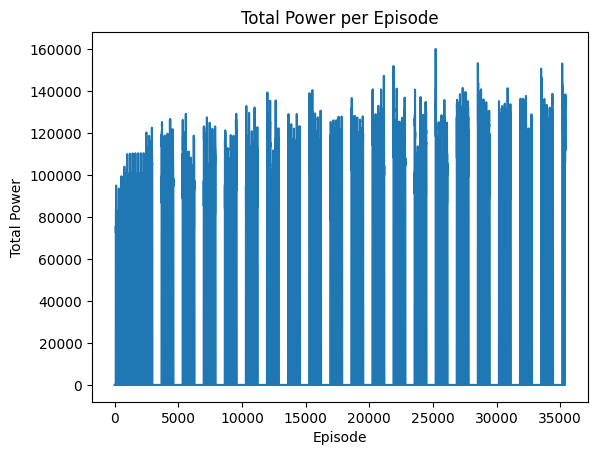

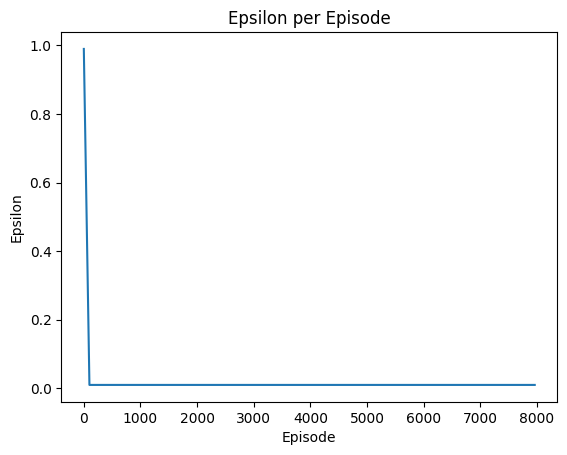

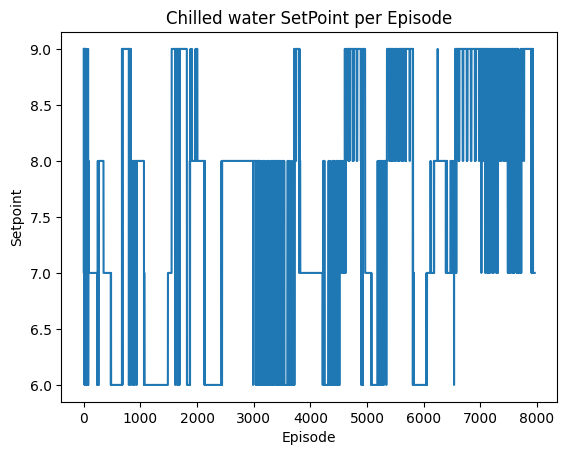

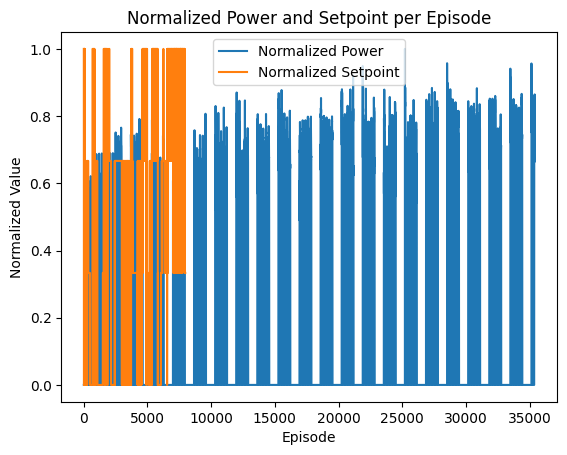

In [10]:
import numpy as np
import matplotlib.pyplot as plt

# Calculate statistics
mean_power = np.mean(powers)
median_power = np.median(powers)
std_power = np.std(powers)
min_power = np.min(powers)
max_power = np.max(powers)

# Print statistics
print(f"Mean Power: {mean_power}")
print(f"Median Power: {median_power}")
print(f"Standard Deviation of Power: {std_power}")
print(f"Minimum Power: {min_power}")
print(f"Maximum Power: {max_power}")

# Plot the data
plt.plot(powers)
plt.xlabel('Episode')
plt.ylabel('Total Power')
plt.title('Total Power per Episode')
plt.show()

plt.plot(eps_history)
plt.xlabel('Episode')
plt.ylabel('Epsilon')
plt.title('Epsilon per Episode')
plt.show()

plt.plot(setpoints)
plt.xlabel('Episode')
plt.ylabel('Setpoint')
plt.title('Chilled water SetPoint per Episode')
plt.show()


In [ ]:
print(scores)